<a href="https://colab.research.google.com/github/lamakye7/Boooking_Analytics/blob/main/Hotel_Check_In_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/Hotel Reservations.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [ ]:
arrival_date

In [ ]:
df["arrival_date"].unique()

array([ 2,  6, 28, 20, 11, 13, 15, 26, 18, 30,  5, 10,  4, 25, 22, 21, 19,
       17,  7,  9, 27,  1, 29, 16,  3, 24, 14, 31, 23,  8, 12])

In [ ]:
 df["booking_status"].value_counts()

,count
booking_status,
Not_Canceled,23851
Canceled,11879


In [ ]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [ ]:
df["room_type_reserved"].value_counts()

,count
room_type_reserved,
Room_Type 1,28130
Room_Type 4,6057
Room_Type 6,966
Room_Type 2,692
Room_Type 5,265
Room_Type 7,158
Room_Type 3,7


In [ ]:
df.groupby("room_type_reserved")["avg_price_per_room"].agg(
    mean_price="mean",
    max_price="max",
    min_price="min"
).reset_index()


,room_type_reserved,mean_price,max_price,min_price
0,Room_Type 1,97.260050,540.00,0.50
1,Room_Type 2,91.141229,284.10,1.60
2,Room_Type 3,103.150000,130.00,65.00
3,Room_Type 4,126.477547,375.50,1.48
4,Room_Type 5,132.215363,250.00,6.00
5,Room_Type 6,185.281684,349.63,6.00
6,Room_Type 7,207.807881,306.00,1.00


In [ ]:
df=df[df["avg_price_per_room"]>0]

In [ ]:


# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df["avg_price_per_room"].quantile(0.25)
Q3 = df["avg_price_per_room"].quantile(0.75)

# Compute IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame
df_clean = df[(df["avg_price_per_room"] >= lower_bound) & (df["avg_price_per_room"] <= upper_bound)]


In [ ]:
df_clean.groupby("room_type_reserved")["avg_price_per_room"].agg(
    mean_price="mean",
    max_price="max",
    min_price="min"
).reset_index()


,room_type_reserved,mean_price,max_price,min_price
0,Room_Type 1,96.838890,181.17,31.00
1,Room_Type 2,90.311453,178.25,23.00
2,Room_Type 3,103.150000,130.00,65.00
3,Room_Type 4,123.688450,181.00,26.35
4,Room_Type 5,123.644908,181.00,35.00
5,Room_Type 6,159.411068,181.20,75.15
6,Room_Type 7,143.089048,181.19,52.00


<Axes: ylabel='avg_price_per_room'>

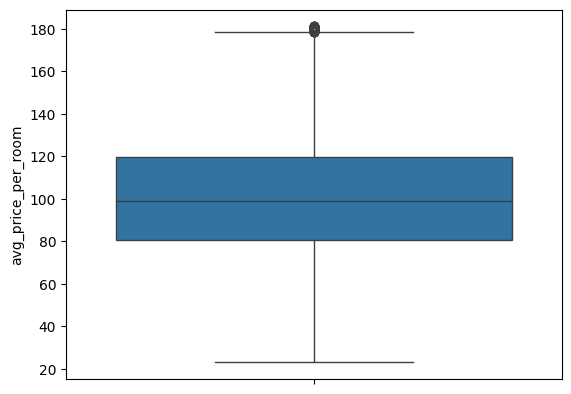

In [ ]:
sns.boxplot(df_clean["avg_price_per_room"])

<Axes: >

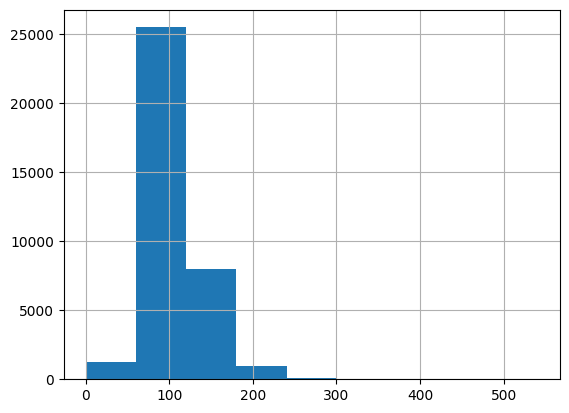

In [ ]:
df["avg_price_per_room"].hist(bins =9)

In [ ]:
 df["booking_status"].unique()

array(['Not_Canceled', 'Canceled'], dtype=object)

In [ ]:
def clean_and_generate_calendar(df):
    """
    Cleans hotel booking data and generates a calendar table.

    Parameters:
    df (pd.DataFrame): Input DataFrame with hotel booking information.

    Returns:
    tuple: (Cleaned DataFrame, Calendar DataFrame)
    """

    # Ensure required columns exist
    required_cols = ["arrival_year", "arrival_month", "arrival_date",
                     "avg_price_per_room", "repeated_guest", "booking_status", "room_type_reserved"]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")

    # Convert to numeric (to handle string issues)
    df["arrival_year"] = pd.to_numeric(df["arrival_year"], errors="coerce")
    df["arrival_month"] = pd.to_numeric(df["arrival_month"], errors="coerce")
    df["arrival_date"] = pd.to_numeric(df["arrival_date"], errors="coerce")

    # Drop rows with NaN values in arrival date columns
    df = df.dropna(subset=["arrival_year", "arrival_month", "arrival_date"])

    # Convert to integer (for valid datetime conversion)
    df["arrival_year"] = df["arrival_year"].astype(int)
    df["arrival_month"] = df["arrival_month"].astype(int)
    df["arrival_date"] = df["arrival_date"].astype(int)

    # Ensure months are between 1 and 12
    df = df[(df["arrival_month"] >= 1) & (df["arrival_month"] <= 12)]

    # Ensure days are within valid range for each month
    df["valid_date"] = df.apply(lambda row:
                                (row["arrival_date"] <= pd.Timestamp(f"{row['arrival_year']}-{row['arrival_month']}-01")
                                 .days_in_month), axis=1)

    df = df[df["valid_date"]]  # Keep only valid dates
    df.drop(columns=["valid_date"], inplace=True)

    # Convert to datetime
    #df["arrival_Date"] = pd.to_datetime(df[["arrival_year", "arrival_month", "arrival_date"]], errors="coerce")
    df["arrival_Date"] = pd.to_datetime(dict(year = df["arrival_year"],
                                             month= df["arrival_month"], day=df["arrival_date"]), errors="coerce")
    df = df.drop(["arrival_year", "arrival_month", "arrival_date"], axis=1)
    # Remove outliers using IQR
    Q1 = df["avg_price_per_room"].quantile(0.25)
    Q3 = df["avg_price_per_room"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df["avg_price_per_room"] >= lower_bound) & (df["avg_price_per_room"] <= upper_bound)]

    # Rename 'repeated_guest' to 'guest_type'
    df = df.rename(columns={"repeated_guest": "guest_type"})
    df["guest_type"] = df["guest_type"].replace({1: "Returning Guest", 0: "First-Time Guest"})

    # Rename 'booking_status' to 'reservation_status'
    df = df.rename(columns={"booking_status": "reservation_status"})
    df["reservation_status"] = df["reservation_status"].replace({
        "Canceled": "Reservation Cancelled",
        "Not_Canceled": "Confirmed Booking"
    })

    # Rename 'room_type_reserved' using mapping
    room_mapping = {
        "Room_Type 1": "Standard Room",
        "Room_Type 2": "Budget Room",
        "Room_Type 3": "Standard Plus",
        "Room_Type 4": "Deluxe Room",
        "Room_Type 5": "Deluxe Room",
        "Room_Type 6": "Executive Room",
        "Room_Type 7": "Premium Room",
    }
    df["room_type_reserved"] = df["room_type_reserved"].replace(room_mapping)
    if df['type_of_meal_plan'] =='Not Selected':
        df['opted_for_meal'] = 'Not Opted'
    else:
        df['opted_for_meal'] = 'Opted'
    # Get min and max dates from 'arrival_Date'
    min_date = df["arrival_Date"].min()
    max_date = df["arrival_Date"].max()

    # Create a calendar DataFrame
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    calendar_df = pd.DataFrame({"date": date_range})

    # Add additional date-based columns
    calendar_df["start_of_week"] = calendar_df["date"] - pd.to_timedelta(calendar_df["date"].dt.weekday, unit='D')
    calendar_df["start_of_month"] = calendar_df["date"].values.astype('datetime64[M]')
    calendar_df["day_name"] = calendar_df["date"].dt.day_name()
    calendar_df["dayofweek"] = calendar_df["date"].dt.dayofweek
    calendar_df["day_number"] = calendar_df["date"].dt.day
    calendar_df["month_name"] = calendar_df["date"].dt.month_name()
    calendar_df["month_number"] = calendar_df["date"].dt.month

    return df, calendar_df

# Example usage:
cleaned_df, calendar_df = clean_and_generate_calendar(df)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
calendar_df.to_csv("calendar_lookup.csv", index=False)

In [ ]:
calendar_df.nunique()

,0
date,549
start_of_week,80
start_of_month,18
day_name,7
dayofweek,7
day_number,31
month_name,12
month_number,12


In [ ]:
cleaned_df.to_csv("Hotel_Reservations_Clean.csv", index=False)

In [ ]:
cleaned_df['type_of_meal_plan'].unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2'], dtype=object)

In [ ]:
cleaned_df.nunique()

,0
Booking_ID,34546
no_of_adults,5
no_of_children,6
no_of_weekend_nights,8
no_of_week_nights,18
type_of_meal_plan,3
required_car_parking_space,2
room_type_reserved,6
lead_time,351
market_segment_type,5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')